# Great Energy predictor using LSTM model

### Abstract:

We are using a dataset related to ASHRAE – Great Energy Predictor III (How much energy will a building consume?). The goal is to develop models from ASHRAE’s 2016 data in order to better understand metered building energy usage in the following areas: chilled water, electric, hot water, and steam meters. The data comes from over 1,000 buildings over a one-year timeframe.

In [1]:
%matplotlib inline
import json
import os
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection  import train_test_split
import numpy as np
import gc
from scipy.stats import norm # for scientific Computing
from scipy import stats, integrate
import matplotlib.pyplot as plt

## 1.Data understanding

In [2]:
#load the dataset
ASHRAE_train = pd.read_csv('/kaggle/input/ashrae-energy-prediction/train.csv')
ASHRAE_test = pd.read_csv('/kaggle/input/ashrae-energy-prediction/test.csv')
weather_train = pd.read_csv('/kaggle/input/ashrae-energy-prediction/weather_train.csv')
weather_test = pd.read_csv('/kaggle/input/ashrae-energy-prediction/weather_test.csv')
building_meta = pd.read_csv('/kaggle/input/ashrae-energy-prediction/building_metadata.csv')

In [3]:
ASHRAE_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB


In [4]:
weather_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int64
timestamp             139773 non-null object
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float64
wind_speed            139469 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB


Reduce some data types to save some memory usage.

In [5]:
## Function to reduce the DF size
def reduce_memory_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
reduce_memory_usage(building_meta)
reduce_memory_usage(weather_train)
reduce_memory_usage(ASHRAE_train)

reduce_memory_usage(weather_test)
reduce_memory_usage(ASHRAE_test)

Mem. usage decreased to  0.03 Mb (60.3% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)


,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00
...,...,...,...,...
41697595,41697595,1444,0,2018-05-09 07:00:00
41697596,41697596,1445,0,2018-05-09 07:00:00
41697597,41697597,1446,0,2018-05-09 07:00:00
41697598,41697598,1447,0,2018-05-09 07:00:00


In [7]:
ASHRAE_train.describe()

,building_id,meter,meter_reading
count,2.021610e+07,2.021610e+07,2.021610e+07
mean,7.992780e+02,6.624412e-01,1.988706e+03
std,4.269133e+02,9.309921e-01,1.532159e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01
50%,8.950000e+02,0.000000e+00,7.877500e+01
75%,1.179000e+03,1.000000e+00,2.679840e+02
max,1.448000e+03,3.000000e+00,2.190470e+07


In [8]:
building_meta.describe()

,site_id,building_id,square_feet,year_built,floor_count
count,1449.000000,1449.000000,1449.000000,675.0000,355.000000
mean,6.952381,724.000000,92111.776398,inf,3.740234
std,5.003432,418.434583,110769.950997,31.0625,3.333984
min,0.000000,0.000000,283.000000,1900.0000,1.000000
25%,3.000000,362.000000,23012.000000,1949.0000,1.000000
50%,5.000000,724.000000,57673.000000,1970.0000,3.000000
75%,13.000000,1086.000000,115676.000000,1995.0000,5.000000
max,15.000000,1448.000000,875000.000000,2017.0000,26.000000


In [9]:
print('number of categories used on "primary_use": ',building_meta['primary_use'].nunique())
print('list of categories used on "primary_use" : ')
print(building_meta['primary_use'].unique())

number of categories used on "primary_use":  16
list of categories used on "primary_use" : 
['Education' 'Lodging/residential' 'Office'
 'Entertainment/public assembly' 'Other' 'Retail' 'Parking'
 'Public services' 'Warehouse/storage' 'Food sales and service'
 'Religious worship' 'Healthcare' 'Utility' 'Technology/science'
 'Manufacturing/industrial' 'Services']


In [10]:
#print train data columns
print('Columns of the building dataset is', building_meta.columns)
print('Columns of the weather_train dataset is', weather_train.columns)
print('Columns of the train dataset is', ASHRAE_train.columns)

Columns of the building dataset is Index(['site_id', 'building_id', 'primary_use', 'square_feet', 'year_built',
       'floor_count'],
      dtype='object')
Columns of the weather_train dataset is Index(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'],
      dtype='object')
Columns of the train dataset is Index(['building_id', 'meter', 'timestamp', 'meter_reading'], dtype='object')


### Messing data in 'building_meta'

In [11]:
building_meta.isnull().sum()

site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64

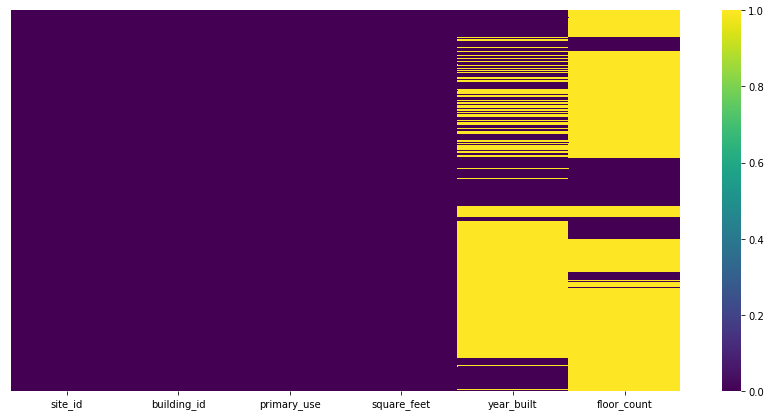

In [12]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(building_meta.isnull(), yticklabels=False, cmap='viridis')

In [13]:
print("Percentage of missing values in the building_meta dataset")
building_meta.isna().sum()/len(building_meta)*100

Percentage of missing values in the building_meta dataset


site_id         0.000000
building_id     0.000000
primary_use     0.000000
square_feet     0.000000
year_built     53.416149
floor_count    75.500345
dtype: float64

In [14]:
print("Percentage of missing values in the train dataset")
ASHRAE_train.isna().sum()/len(ASHRAE_train)*100

Percentage of missing values in the train dataset


building_id      0.0
meter            0.0
timestamp        0.0
meter_reading    0.0
dtype: float64

In [15]:
print("Percentage of missing values in the weather_train dataset")
weather_train.isna().sum()/len(weather_train)*100

Percentage of missing values in the weather_train dataset


site_id                0.000000
timestamp              0.000000
air_temperature        0.039350
cloud_coverage        49.489529
dew_temperature        0.080845
precip_depth_1_hr     35.979052
sea_level_pressure     7.596603
wind_direction         4.484414
wind_speed             0.217496
dtype: float64

## 2.Data preparation

In [16]:
#merging tables
BuildingTrain = building_meta.merge(ASHRAE_train, left_on='building_id', right_on='building_id' , how='left')
BuildingTest = building_meta.merge(ASHRAE_test, left_on='building_id', right_on='building_id' , how='left')
BuildingTrain.shape, BuildingTest.shape

((20216100, 9), (41697600, 9))

In [17]:
BuildingTrain.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count,meter,timestamp,meter_reading
0,0,0,Education,7432,2008.0,NaN,0,2016-01-01 00:00:00,0.0
1,0,0,Education,7432,2008.0,NaN,0,2016-01-01 01:00:00,0.0
2,0,0,Education,7432,2008.0,NaN,0,2016-01-01 02:00:00,0.0
3,0,0,Education,7432,2008.0,NaN,0,2016-01-01 03:00:00,0.0
4,0,0,Education,7432,2008.0,NaN,0,2016-01-01 04:00:00,0.0


In [18]:
del ASHRAE_test
del ASHRAE_train
del building_meta
gc.collect()

21

In [19]:
BTW_train=BuildingTrain.merge(weather_train,left_on=['site_id','timestamp'],right_on=['site_id','timestamp'],how='left')
BTW_test = BuildingTest.merge(weather_test,left_on=['site_id','timestamp'],right_on=['site_id','timestamp'],how='left')
BTW_train.shape

(20216100, 16)

In [20]:
del BuildingTest
del BuildingTrain
del weather_test
del weather_train
gc.collect()

0

In [21]:
BTW_train.columns

Index(['site_id', 'building_id', 'primary_use', 'square_feet', 'year_built',
       'floor_count', 'meter', 'timestamp', 'meter_reading', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed'],
      dtype='object')

In [22]:
BTW_train.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count,meter,timestamp,meter_reading,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,Education,7432,2008.0,NaN,0,2016-01-01 00:00:00,0.0,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.000000
1,0,0,Education,7432,2008.0,NaN,0,2016-01-01 01:00:00,0.0,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.500000
2,0,0,Education,7432,2008.0,NaN,0,2016-01-01 02:00:00,0.0,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000
3,0,0,Education,7432,2008.0,NaN,0,2016-01-01 03:00:00,0.0,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000
4,0,0,Education,7432,2008.0,NaN,0,2016-01-01 04:00:00,0.0,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609


In [23]:
print("Percentage of missing values in the BTW_train dataset")
BTW_train.isna().sum()/len(BTW_train)*100

Percentage of missing values in the BTW_train dataset


site_id                0.000000
building_id            0.000000
primary_use            0.000000
square_feet            0.000000
year_built            59.990033
floor_count           82.652772
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
air_temperature        0.478124
cloud_coverage        43.655131
dew_temperature        0.495348
precip_depth_1_hr     18.544739
sea_level_pressure     6.092515
wind_direction         7.167792
wind_speed             0.710701
dtype: float64

,sea_level_pressure
count,18984431.0
mean,NaN
std,NaN
min,968.0
25%,1011.5
50%,1016.0
75%,1020.5
max,1046.0


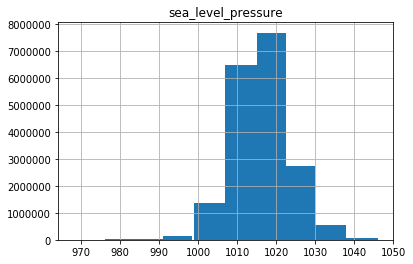

In [24]:
BTW_train.hist('sea_level_pressure')
BTW_train[['sea_level_pressure']].describe()

,cloud_coverage
count,11390735.0
mean,NaN
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,4.0
max,9.0


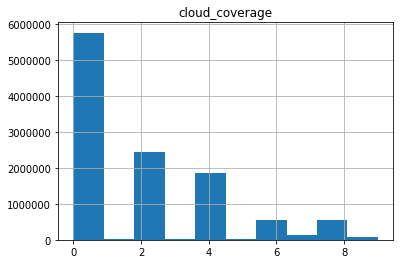

In [25]:
BTW_train.hist('cloud_coverage')
BTW_train[['cloud_coverage']].describe()

,precip_depth_1_hr
count,16467077.0
mean,NaN
std,NaN
min,-1.0
25%,0.0
50%,0.0
75%,0.0
max,343.0


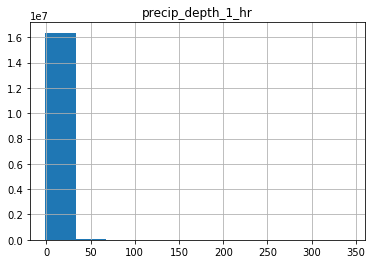

In [26]:
BTW_train.hist('precip_depth_1_hr')
BTW_train[['precip_depth_1_hr']].describe()

In [27]:
def plot_dist(df, column):
    plt.figure(figsize=(18,12))
    ax = sns.distplot(df[column].dropna())
    ax.set_title(column+" Distribution", fontsize=16)
    plt.xlabel(column, fontsize=12)
    #plt.ylabel("distribution", fontsize=12)
    plt.show()

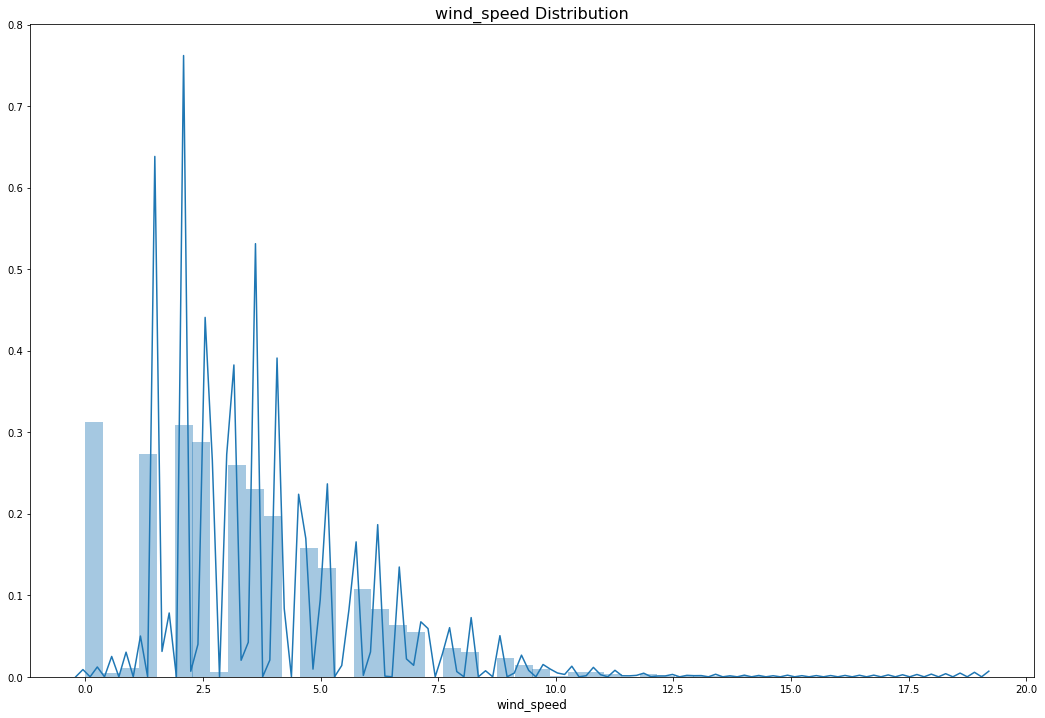

In [28]:
BTW_train[['wind_speed']].describe()
plot_dist(BTW_train,'wind_speed')

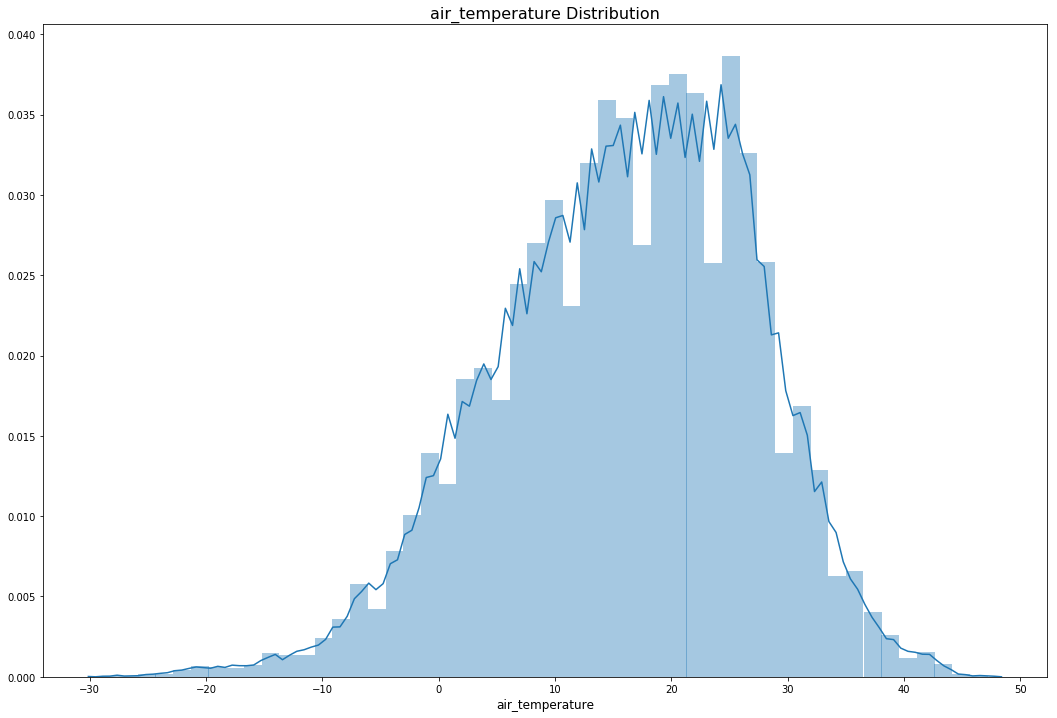

In [29]:
BTW_train[['air_temperature']].describe()
plot_dist(BTW_train,'air_temperature')

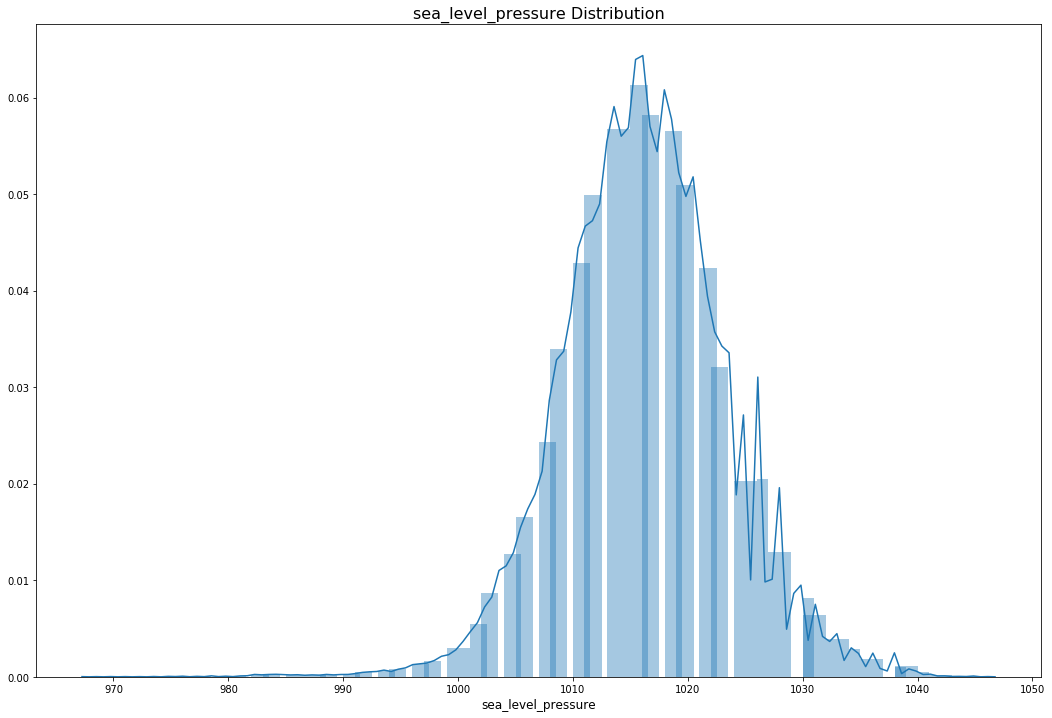

In [30]:
plot_dist(BTW_train, "sea_level_pressure")

meter - The meter id code Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.

meter_reading - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error. UPDATE: as discussed here, the site 0 electric meter readings are in kBTU.

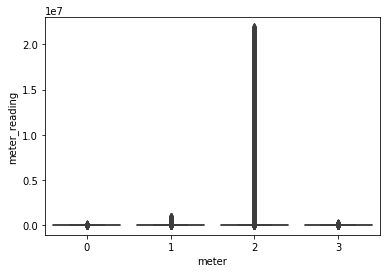

In [31]:
sns.boxplot(x = 'meter', y = 'meter_reading', data = BTW_train)

In [32]:
def outlier_function(df, col_name):
    ''' this function detects first and third quartile and interquartile range for a given column of a dataframe
    then calculates upper and lower limits to determine outliers conservatively
    returns the number of lower and uper limit and number of outliers respectively
    '''
    first_quartile = np.percentile(
        np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(
        np.array(df[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile
                      
    upper_limit = third_quartile+(3*IQR)
    lower_limit = first_quartile-(3*IQR)
    outlier_count = 0
                      
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
    return lower_limit, upper_limit, outlier_count

In [33]:
print("{} percent of {} are outliers."
      .format((
              (100 * outlier_function(BTW_train, 'meter_reading')[2])
               / len(BTW_train['meter_reading'])),
              'meter_reading'))

7.865537863386113 percent of meter_reading are outliers.


Text(0.5, 1.0, 'Density of Logartihm(Meter Reading + 1) Among Different Meters')

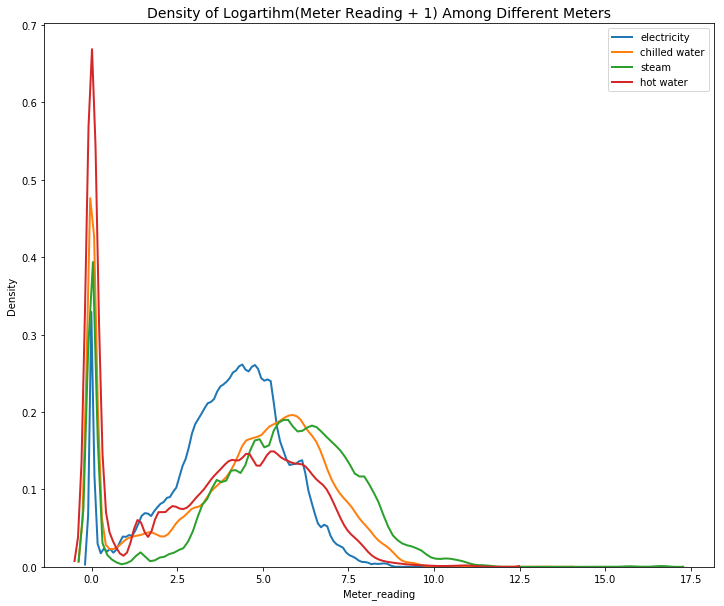

In [34]:
# Distribution of the meter reading in meters without zeros
plt.figure(figsize=(12,10))

#list of different meters
meters = sorted(BTW_train['meter'].unique().tolist()) # [0, 1, 2, 3]

# plot meter_reading distribution for each meter
for meter_type in meters:
    subset = BTW_train[BTW_train['meter'] == meter_type]
    sns.kdeplot(np.log1p(subset["meter_reading"]), 
                label=meter_type, linewidth=2)

# set title, legends and labels
plt.ylabel("Density")
plt.xlabel("Meter_reading")
plt.legend(['electricity', 'chilled water', 'steam', 'hot water'])
plt.title("Density of Logartihm(Meter Reading + 1) Among Different Meters", size=14)

In [35]:
BTW_train.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count,meter,timestamp,meter_reading,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,Education,7432,2008.0,NaN,0,2016-01-01 00:00:00,0.0,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.000000
1,0,0,Education,7432,2008.0,NaN,0,2016-01-01 01:00:00,0.0,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.500000
2,0,0,Education,7432,2008.0,NaN,0,2016-01-01 02:00:00,0.0,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000
3,0,0,Education,7432,2008.0,NaN,0,2016-01-01 03:00:00,0.0,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000
4,0,0,Education,7432,2008.0,NaN,0,2016-01-01 04:00:00,0.0,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609


In [36]:
BTW_train.columns

Index(['site_id', 'building_id', 'primary_use', 'square_feet', 'year_built',
       'floor_count', 'meter', 'timestamp', 'meter_reading', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed'],
      dtype='object')

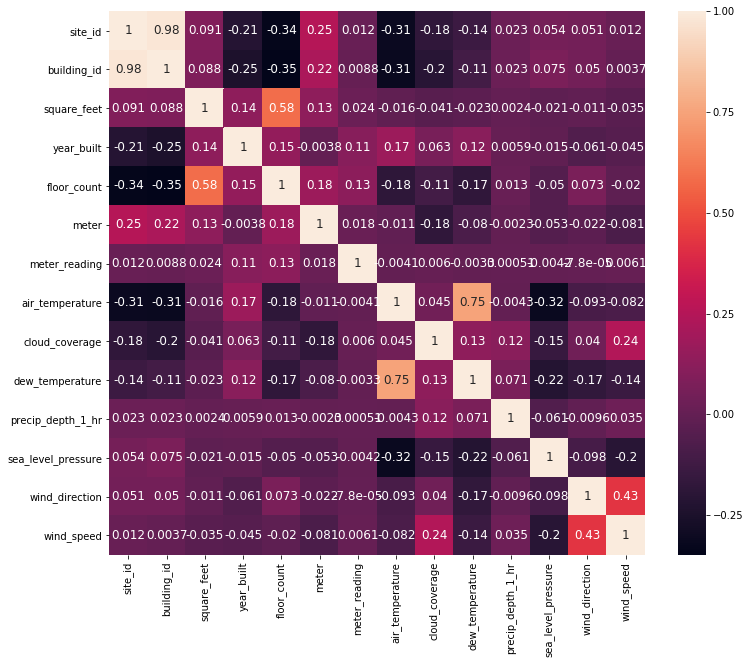

In [37]:
corrmat=BTW_train.corr()
fig,ax=plt.subplots(figsize=(12,10))
sns.heatmap(corrmat,annot=True,annot_kws={'size': 12})

### Dropping columns and filling null value

In [38]:
BTW_train = BTW_train.drop(columns=['year_built', 'floor_count', 'wind_direction', 'dew_temperature'])
BTW_test = BTW_test.drop(columns=['year_built', 'floor_count','wind_direction', 'dew_temperature'])

In [39]:
BTW_train ['timestamp'] =  pd.to_datetime(BTW_train['timestamp'])
BTW_test ['timestamp'] =  pd.to_datetime(BTW_test['timestamp'])
BTW_train['Month']=pd.DatetimeIndex(BTW_train['timestamp']).month
BTW_test['Month']=pd.DatetimeIndex(BTW_test['timestamp']).month
BTW_train['Day']=pd.DatetimeIndex(BTW_train['timestamp']).day
BTW_test['Day']=pd.DatetimeIndex(BTW_test['timestamp']).day

In [40]:
BTW_train= BTW_train.groupby(['meter',BTW_train['building_id'],'primary_use',BTW_train['Month'], BTW_train['Day']]).agg({'meter_reading':'sum', 'air_temperature': 'mean', 'wind_speed': 'mean', 'precip_depth_1_hr': 'mean', 'cloud_coverage': 'mean', 'square_feet': 'mean'})
BTW_test_1= BTW_test.groupby(['row_id','meter',BTW_test['building_id'],'primary_use',BTW_test['Month'], BTW_test['Day']]).agg({ 'air_temperature': 'mean', 'wind_speed': 'mean', 'precip_depth_1_hr': 'mean', 'cloud_coverage': 'mean', 'square_feet': 'mean'})

In [41]:
BTW_train.isna().sum()

meter_reading             0
air_temperature           1
wind_speed                2
precip_depth_1_hr    118283
cloud_coverage        59054
square_feet               0
dtype: int64

In [42]:
BTW_train = BTW_train.reset_index()

In [43]:
BTW_train.describe()

,meter,building_id,Month,Day,meter_reading,air_temperature,wind_speed,precip_depth_1_hr,cloud_coverage,square_feet
count,845701.000000,845701.000000,845701.000000,845701.000000,8.457010e+05,845700.000000,845699.000000,727418.000000,786647.000000,845701.000000
mean,0.663664,800.092567,6.577496,15.762940,5.059369e+04,NaN,NaN,NaN,NaN,107709.359699
std,0.931187,427.003416,3.437662,8.821962,3.569942e+06,0.000000,0.000000,0.000000,0.000000,117038.604587
min,0.000000,0.000000,1.000000,1.000000,0.000000e+00,-24.921875,0.000000,-1.000000,0.000000,283.000000
25%,0.000000,394.000000,4.000000,8.000000,5.284870e+02,8.898438,2.250000,0.000000,0.500000,32527.000000
50%,0.000000,896.000000,7.000000,16.000000,2.042660e+03,17.046875,3.099609,0.000000,1.799805,72709.000000
75%,1.000000,1180.000000,10.000000,23.000000,6.619375e+03,23.718750,4.222656,0.083313,3.714844,139113.000000
max,3.000000,1448.000000,12.000000,31.000000,4.611469e+08,40.187500,14.414062,81.000000,9.000000,875000.000000


Change data type to float 32 for filling NA value before transforming them into int for smooth modeling processing

In [44]:
BTW_train['wind_speed'] = BTW_train['wind_speed'].astype('float32')
BTW_train['air_temperature'] = BTW_train['air_temperature'].astype('float32')
BTW_train['precip_depth_1_hr'] = BTW_train['precip_depth_1_hr'].astype('float32')
BTW_train['cloud_coverage'] = BTW_train['cloud_coverage'].astype('float32')
BTW_test['wind_speed'] = BTW_test['wind_speed'].astype('float32')
BTW_test['air_temperature'] = BTW_test['air_temperature'].astype('float32')
BTW_test['precip_depth_1_hr'] = BTW_test['precip_depth_1_hr'].astype('float32')
BTW_test['cloud_coverage'] = BTW_test['cloud_coverage'].astype('float32')

In [45]:
BTW_train['precip_depth_1_hr'].fillna(method='ffill', inplace = True)
BTW_train['cloud_coverage'].fillna(method='bfill', inplace = True)

BTW_train['wind_speed'].fillna(BTW_train['wind_speed'].mean(), inplace=True)
BTW_train['air_temperature'].fillna(BTW_train['air_temperature'].mean(), inplace=True)

BTW_test['precip_depth_1_hr'].fillna(method='ffill', inplace = True)
BTW_test['cloud_coverage'].fillna(method='bfill', inplace = True)
BTW_test['precip_depth_1_hr'].fillna(BTW_test['precip_depth_1_hr'].mean(), inplace=True)
BTW_test['cloud_coverage'].fillna(BTW_test['cloud_coverage'].mean(), inplace=True)

BTW_test['wind_speed'].fillna(BTW_test['wind_speed'].mean(), inplace=True)
BTW_test['air_temperature'].fillna(BTW_test['air_temperature'].mean(), inplace=True)
BTW_train.isnull().sum()

meter                0
building_id          0
primary_use          0
Month                0
Day                  0
meter_reading        0
air_temperature      0
wind_speed           0
precip_depth_1_hr    0
cloud_coverage       0
square_feet          0
dtype: int64

In [46]:
BTW_train.shape,BTW_train.dtypes

((845701, 11), meter                  int64
 building_id            int64
 primary_use           object
 Month                  int64
 Day                    int64
 meter_reading        float32
 air_temperature      float32
 wind_speed           float32
 precip_depth_1_hr    float32
 cloud_coverage       float32
 square_feet            int32
 dtype: object)

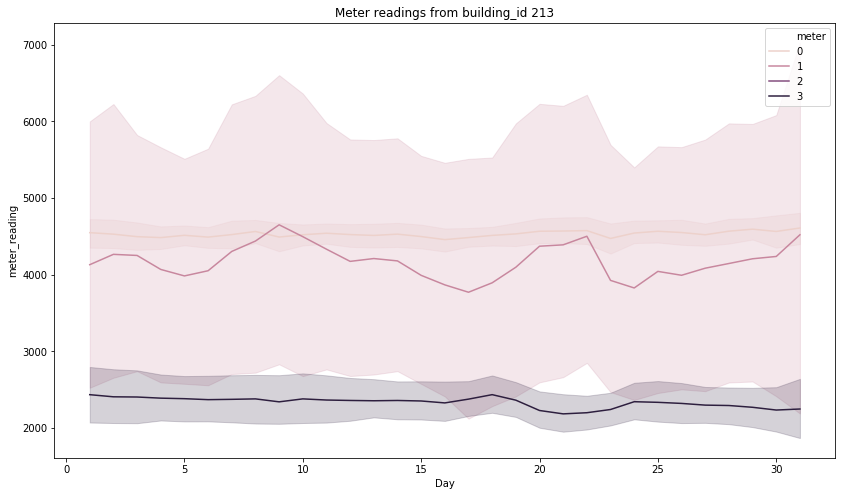

In [47]:
#visualization of meter reading for a specific building_id
# by Day
building_id = 213
plt.figure(figsize=(14, 8))
ax = sns.lineplot(x="Day", y="meter_reading", hue="meter", data=BTW_train[BTW_train['building_id'] == building_id])
plt.title('Meter readings from building_id {}'.format(building_id))
plt.show()

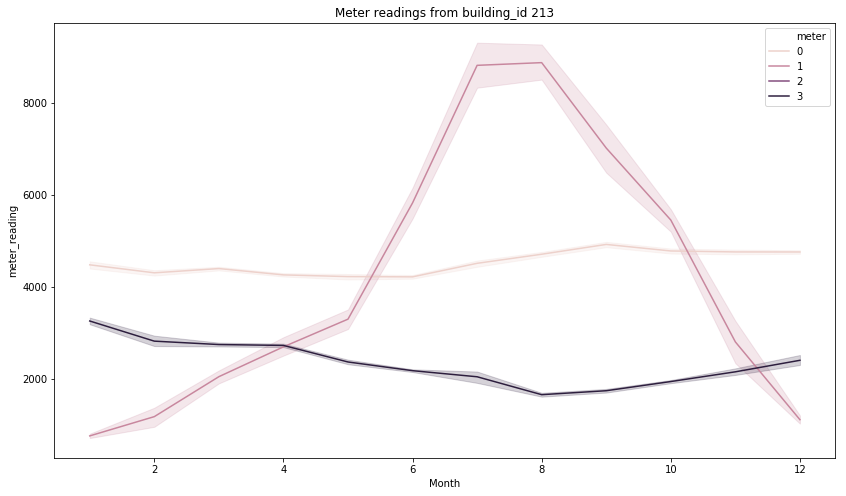

In [48]:
#visualization of meter reading for a specific building_id
# by Month
building_id = 213
plt.figure(figsize=(14, 8))
ax = sns.lineplot(x="Month", y="meter_reading", hue="meter", data=BTW_train[BTW_train['building_id'] == building_id])
plt.title('Meter readings from building_id {}'.format(building_id))
plt.show()

### Primary_use data encoding 

In [49]:
BTW_train.primary_use.unique()

array(['Education', 'Lodging/residential', 'Office',
       'Entertainment/public assembly', 'Other', 'Retail', 'Parking',
       'Public services', 'Warehouse/storage', 'Food sales and service',
       'Religious worship', 'Healthcare', 'Utility', 'Technology/science',
       'Manufacturing/industrial', 'Services'], dtype=object)

In [50]:
BTW_train.head()

,meter,building_id,primary_use,Month,Day,meter_reading,air_temperature,wind_speed,precip_depth_1_hr,cloud_coverage,square_feet
0,0,0,Education,1,1,0.0,23.343750,1.854492,-0.173950,4.285156,7432
1,0,0,Education,1,2,0.0,19.531250,3.925781,-0.083313,5.667969,7432
2,0,0,Education,1,3,0.0,14.828125,5.000000,0.500000,8.000000,7432
3,0,0,Education,1,4,0.0,12.664062,4.285156,0.666504,2.427734,7432
4,0,0,Education,1,5,0.0,14.062500,6.257812,0.000000,1.333008,7432


In [51]:
BTW_encoded = BTW_train[:]
BTW_test_encoded = BTW_test[:]

In [52]:
# label encoding 
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
BTW_encoded["primary_use"] = le.fit_transform(BTW_encoded["primary_use"])
BTW_test_encoded["primary_use"] = le.fit_transform(BTW_test_encoded["primary_use"])

In [53]:
BTW_encoded.columns

Index(['meter', 'building_id', 'primary_use', 'Month', 'Day', 'meter_reading',
       'air_temperature', 'wind_speed', 'precip_depth_1_hr', 'cloud_coverage',
       'square_feet'],
      dtype='object')

### Preparing dataset

In [54]:
X = BTW_encoded[['meter', 'building_id', 'primary_use', 'Month', 'Day','air_temperature', 'wind_speed', 'precip_depth_1_hr', 'cloud_coverage',
       'square_feet']]
y = BTW_encoded['meter_reading']

In [55]:
x_train, x_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state= 45)

# 3.Deep learning model

In [56]:
from sklearn import preprocessing
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, LSTM, GRU, Dropout, BatchNormalization
from keras.models import Sequential
from keras.optimizers import RMSprop,Adam
from keras import regularizers

Using TensorFlow backend.


In [57]:
def root_mean_squared_error(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [58]:
def make_model(input_dim=10,metrics=root_mean_squared_error,loss='mse', optimizer="rmsprop",drop_rate=0.5):

  model = Sequential()
  model.add(LSTM(128,return_sequences=True, input_shape=(None,input_dim)))
  model.add(Dropout(drop_rate))
  model.add(BatchNormalization())
  model.add(LSTM(128,return_sequences=False))
  model.add(BatchNormalization())
  model.add(Dropout(drop_rate))
  model.add(Dense(1))
  model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])
  
  return model

In [59]:
def run_model(model,x_train,y_train,epochs=50,batch_size=500,verbose=1,validation_data=(x_val,y_val),callbacks =None):
  x_train = x_train.values[:]
  x_train= x_train.reshape((x_train.shape[0],1,x_train.shape[-1]))
  y_train = np.log1p(y_train)
  if validation_data != None:
    x_val = validation_data[0].values[:]
    x_val = x_val.reshape((x_val.shape[0],1,x_val.shape[-1]))
    y_val = np.log1p(validation_data[-1])
      
  return model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=verbose,validation_data=(x_val,y_val),callbacks=callbacks)

In [60]:
#best_model_file = "my_model.h5"
#mc = ModelCheckpoint(best_model_file, monitor='val_loss', mode='auto',verbose=True, save_best_only=True)
es = EarlyStopping(monitor='val_root_mean_squared_error', min_delta=0.0001, patience=5, verbose=True, mode='auto')

In [61]:
model = make_model(input_dim=x_train.shape[-1],drop_rate=0.2)

In [62]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 128)         71168     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 128)         512       
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [63]:
history = run_model(model,x_train,y_train,epochs=30,batch_size=500,verbose=1,validation_data=(x_val,y_val), callbacks =[es]) # callbacks =[mc, es]

Train on 676560 samples, validate on 169141 samples
Epoch 1/30
676560/676560 [==============================] - 20s 30us/step - loss: 10.1790 - root_mean_squared_error: 2.9962 - val_loss: 7.1632 - val_root_mean_squared_error: 2.6751
Epoch 2/30
676560/676560 [==============================] - 18s 27us/step - loss: 6.6047 - root_mean_squared_error: 2.5675 - val_loss: 6.6544 - val_root_mean_squared_error: 2.5774
Epoch 3/30
676560/676560 [==============================] - 18s 26us/step - loss: 6.6845 - root_mean_squared_error: 2.5828 - val_loss: 6.8324 - val_root_mean_squared_error: 2.6124
Epoch 4/30
676560/676560 [==============================] - 18s 26us/step - loss: 6.6631 - root_mean_squared_error: 2.5786 - val_loss: 6.4157 - val_root_mean_squared_error: 2.5306
Epoch 5/30
676560/676560 [==============================] - 18s 26us/step - loss: 6.5805 - root_mean_squared_error: 2.5628 - val_loss: 6.4173 - val_root_mean_squared_error: 2.5309
Epoch 6/30
676560/676560 [=====================

In [64]:
loss = history.history
loss.keys()

dict_keys(['val_loss', 'val_root_mean_squared_error', 'loss', 'root_mean_squared_error'])

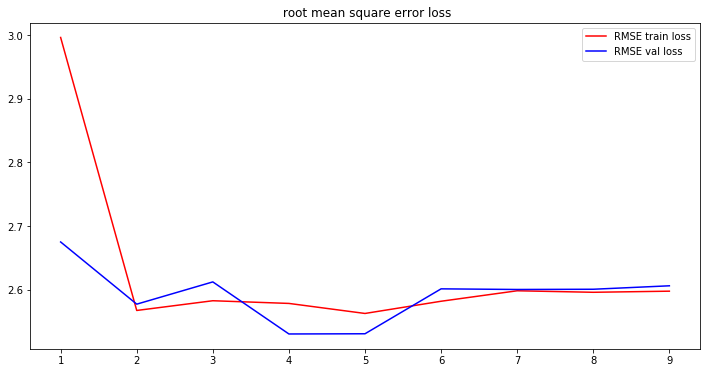

In [65]:
#rmse loss
rmse_loss_train = loss['root_mean_squared_error']
rmse_loss_val = loss['val_root_mean_squared_error']
epochs_stops = es.stopped_epoch +1 # epochs number from early stopping
epochs = range(1,epochs_stops + 1)  #len(loss_train)
plt.figure(figsize=(12,6))
plt.plot(epochs,rmse_loss_train,'r', label='RMSE train loss')
plt.plot(epochs,rmse_loss_val,'b',label='RMSE val loss')
plt.title(' root mean square error loss')
plt.legend()
plt.show()

## Submitting

In [66]:
# submit = pd.read_csv('/kaggle/input/ashrae-energy-prediction/sample_submission.csv')

In [67]:
# x_test = BTW_test[['meter', 'building_id', 'primary_use', 'Month', 'Day','air_temperature', 'wind_speed', 'precip_depth_1_hr', 'cloud_coverage',#
#        'square_feet']]
# x_test = x_test.values[:]
# x_test = x_test.reshape((x_test.shape[0],1,x_test.shape[-1]))

In [68]:
# prediction = history.predict(x_test)

In [69]:
# prediction = np.expm1(prediction)

In [70]:
# submit['meter_reading'] = prediction

In [71]:
# submit.to_csv('submission.csv', index=False,float_format='%.4f')